<a href="https://colab.research.google.com/github/ejlanz/Kaggle_Personality_Profile_Predictions_NLP_Classification_EDSA_CPT_Team5/blob/master/Classi5_Personality_Profile_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personality Profile Prediction
---

## EDSA CPT Team Classi5

<img  src="https://cdn.shopify.com/s/files/1/0100/5392/articles/Mouthpiece_VdayMeyersBriggs1.progressive.jpg?v=1549578121" data-iml="1561547447318" style='width:600px'>

# Overview

1. Introduction to the data and outline goal of the competition
2. Importing the packages and the data
3. Data exploration
4. Data preprocessing
5. Building the Model
6. Prediction on test data
6. Conclusion

# Introduction

The Myers-Briggs Type Indicator (MBTI) is a psychological assessment tool used to classify people into one of 16 different personality types.  The classification system consists of a four-letter code based on four dimensions, where each letter in the code refers to the predominant trait in each dimension. The four dimensions are:
- **Mind: Introverted (I)** or **Extraverted (E)** which describes the different attitudes people use to direct their energy (i.e. the "inner world" vs. one's "outer world").
- **Energy: Sensing (S)** or **Intuitive (N)** which describes people's method of processing informaton (i.e. paying more attention to the patterns and possibilities seen in the information received vs. information that comes in through the five senses)
- **Nature: Feeling (F)** or **Thinking (T)** which describes people's method for making decisions (i.e. putting more weight on objective principles and impersonal facts vs. personal concerns and the people involved).
- **Tactics: Perceiving (P)** or **Judging (J)** which describes people's orientation to the outside world and the behaviors one exhibits (i.e. preferring a structured and decided lifestyle vs. a more flexible and adaptive lifestyle)


The letters associated with an individual's preferences are combined to get the Myers Briggs personality type.
The goal of the competition is to build and train a model that is capable of predicting labels for each of the four MBTI variables.

### Package Imports

In [0]:
# Packages

import pandas as pd
import numpy as np
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# Visualisation

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


# Model Building

    #classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

    #vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

    #training features
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

    #performance measures
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer

    #filter future warnings
#two futre warnings occured multiple times when running cross validation and GridSearchCV have been removed
#FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
#FutureWarning: The default value of cv will change from 3 to 5 in version 0.22
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploratory Data Analysis (EDA)

In [0]:
# view the data
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [0]:
test.head()

,id,posts
0,1,Musical Linguistic Logic & Naturalist (tied)|...
1,2,'You: hello :) Stranger: hii You: how are you ...
2,3,'What worked for me was knowing that limerence...
3,4,'Please forget about him. You should definitel...
4,5,"'Ooh, ENTJ Celestia is actually an interesting..."


In [0]:
print('Number of rows and columns in train data:{}' .format(train.shape))
print('Number of rows and columns in test data:{}' .format(test.shape))

Number of rows and columns in train data:(6506, 2)
Number of rows and columns in test data:(2169, 2)


#### Is there any missing data in any of the columns?

In [0]:
train.isnull().sum()

type     0
posts    0
dtype: int64

In [0]:
test.isnull().sum()

id       0
posts    0
dtype: int64

#### How many posts were written by each personality type?

In [0]:
type_sum = train.groupby(['type']).count()
type_sum.sort_values('posts', ascending=False, inplace=True)
type_sum

,posts
type,
INFP,1386
INFJ,1100
INTP,960
INTJ,830
ENTP,530
ENFP,496
ISTP,255
ISFP,198
ENTJ,167


#### How many total words were written by each personality type?

In [0]:
train['word_count'] = train['posts'].apply(lambda x: len(str(x).split(" ")))
word_count = train.groupby('type').sum()
word_count.sort_values('word_count', ascending=False, inplace=True)
word_count

,word_count
type,
INFP,1766459
INFJ,1433173
INTP,1182968
INTJ,1021534
ENTP,657644
ENFP,640173
ISTP,309575
ISFP,228704
ENTJ,211562


In [0]:
#drop word_count column
train = train.drop(['word_count'], axis=1)

While the "INFP" personality wrote the most posts and  wrote the most words in their posts.The personality that wrote the least posts was 'ESTJ' and the personality with the least written words was 'ESFP'. 

#### Distribution of the Personality Types

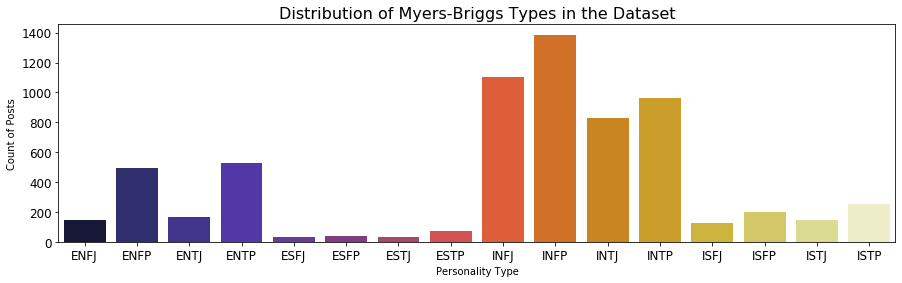

In [0]:
dim = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dim)
cmrmap = sns.color_palette('CMRmap', 16)
sns.set_palette(cmrmap)
sns.countplot(x='type', data=train,
              order=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ',
                     'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP',
                     'ISTJ', 'ISTP'])
plt.title('Distribution of Myers-Briggs Types in the Dataset', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Count of Posts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The 'ES' personality types have the least posts, whilst the 'IN' personalities have the most posts. This suggests that the data is imbalanced.

In [0]:
# Create a binary column for each of the 4 dimension types
train['Mind'] = train['type'].map(lambda x: 'Extroverted'
                                  if x[0] == 'E' else 'Introverted')
train['Energy'] = train['type'].map(lambda x: 'Intuitive'
                                    if x[1] == 'N' else 'Sensing')
train['Nature'] = train['type'].map(lambda x: 'Thinking'
                                    if x[2] == 'T' else 'Feeling')
train['Tactics'] = train['type'].map(lambda x: 'Judging'
                                     if x[3] == 'J' else 'Perceiving')

### Mind

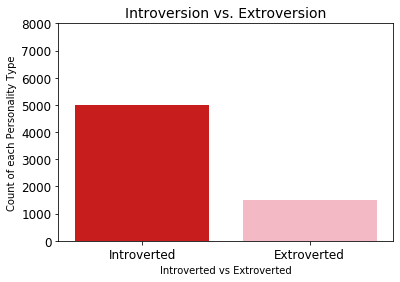

In [0]:
# Countplot of the Introverted - Extroverted variable
IEcolors = sns.xkcd_palette(['red', 'soft pink'])
sns.set_palette(IEcolors)
sns.countplot(x='Mind', data=train, order=['Introverted', 'Extroverted'])
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Introverted vs Extroverted')
plt.ylabel('Count of each Personality Type')
plt.title('Introversion vs. Extroversion', fontsize=14)
plt.show()


There are more introverts who have written posts compare to extroverts. Now let's assess the most common words spoken by each.

In [0]:
# Start with one review:
def generate_wordcloud(text, title):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color='white').generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=40)
    plt.show()

In [0]:
# Group together posts written by those under the mind variable
words_of_mind = train.groupby('Mind')['posts'].apply(' '.join).reset_index()

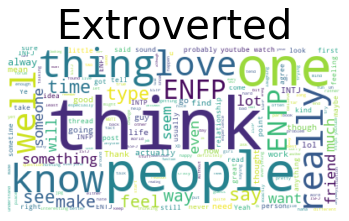

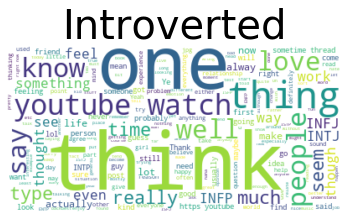

In [0]:
for i, t in enumerate(words_of_mind['Mind']):
    text = words_of_mind.iloc[i,1]
    generate_wordcloud(text, t)

### Energy

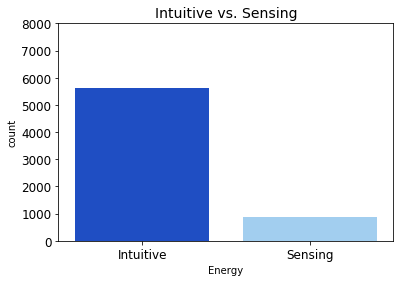

In [0]:
# Countplot of the Intuitive - Sensing variable
NScolors = sns.xkcd_palette(['blue', 'light blue'])
sns.set_palette(NScolors)
sns.countplot(x='Energy', data=train, order=['Intuitive', 'Sensing'])
plt.title('Intuitive vs. Sensing', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

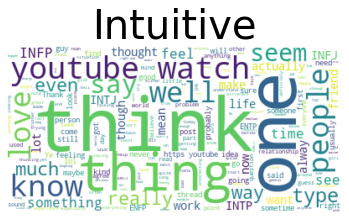

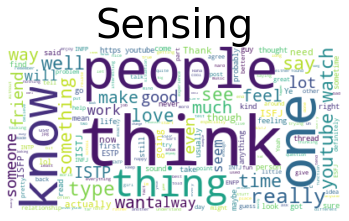

In [0]:
words_of_energy = train.groupby('Energy')['posts'].apply(' '.join).reset_index()
for i, t in enumerate(words_of_energy['Energy']):
    text = words_of_energy.iloc[i, 1]
    generate_wordcloud(text, t)

### Nature

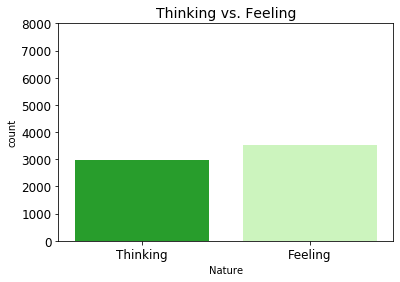

In [0]:
# Countplot of the Tinking - Feeling variable
TFcolors = sns.xkcd_palette(['green', 'pale green'])
sns.set_palette(TFcolors)
sns.countplot(x='Nature', data=train, order=['Thinking', 'Feeling'])
plt.title('Thinking vs. Feeling', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

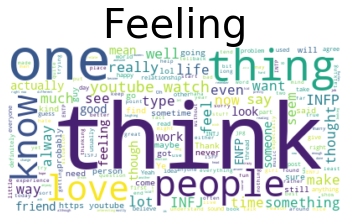

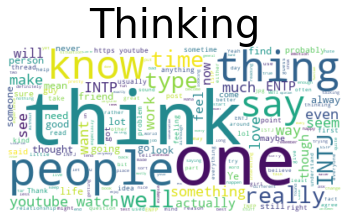

In [0]:
words_of_nature = train.groupby('Nature')['posts'].apply(' '.join).reset_index()
for i, t in enumerate(words_of_nature['Nature']):
    text = words_of_nature.iloc[i, 1]
    generate_wordcloud(text, t)

### Tactics

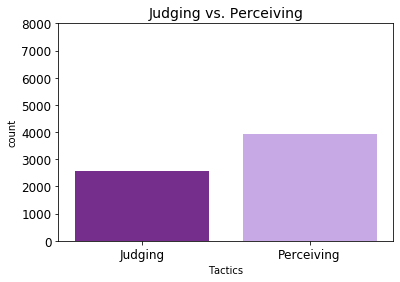

In [0]:
# Countplot of Judging - Perceiving
JPcolors = sns.xkcd_palette(['purple', 'lavender'])
sns.set_palette(JPcolors)
sns.countplot(x='Tactics', data=train, order=['Judging', 'Perceiving'])
plt.title('Judging vs. Perceiving', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

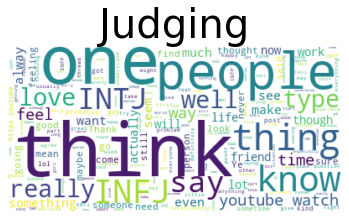

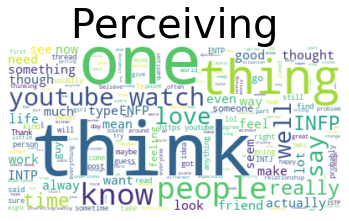

In [0]:
words_of_tactics = train.groupby('Tactics')['posts'].apply(' '.join).reset_index()
for i, t in enumerate(words_of_tactics['Tactics']):
    text = words_of_tactics.iloc[i, 1]
    generate_wordcloud(text, t)

The 'Nature' variable containing 'Thinking - Feeling' is more balanced compared to other variables. 

The word that seems to appear the most among all the personalities is the word 'think'.

# Data Preprocessing

The data has to be preprocessed with the purpose of removing noise, which negatively affects the accuracy of the model. Both the train and test data were preprocessed.

#### Removing delimeters

Each person's posts were made up of 50 individual posts which were separated by  the string '|||'. There was an attempt to split the data,converting each post into the 50 individual posts, with the goal of increasing the size of the dataset (especially those personalities with very few posts). However this method reduced the accuracy  of the model and was abandoned. We therefore removed the delimiters as part of the preprocessing. 

In [0]:
def remove_delimiters (post):
    new = post.replace('|||',' ')
    return ' '.join(new.split())

train['posts'] = train['posts'].apply(remove_delimiters)
test['posts'] = test['posts'].apply(remove_delimiters)

#### Removing URLs

Urls don't add any value when analyzing text therefore they were removed(https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41).

In [0]:
## Remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'

#apply to train set
train['posts'] = train['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)

#apply to test set
test['posts'] = test['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)

#### Convert words to lowercase

Words were converted to lowercase in order to remove noise from capitalisation and to avoid having multiple copies of the same words(eg.'People vs people')(https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)

In [0]:
train['posts'] = train['posts'].str.lower()

test['posts'] = test['posts'].str.lower()

#### Remove punctuation and numbers 

Punctuation doesn’t add any extra information to the text data therefore removing it will help reduce the size of the training data.

In [0]:
#Remove punctuation & numbers
def remove_punctuation(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])

train['posts'] = train['posts'].apply(remove_punctuation)

test['posts'] = test['posts'].apply(remove_punctuation)

In [0]:
train.head()

,type,posts,Mind,Energy,Nature,Tactics
0,INFJ,urlweb urlweb enfp and intj moments urlweb spo...,Introverted,Intuitive,Feeling,Judging
1,ENTP,im finding the lack of me in these posts very ...,Extroverted,Intuitive,Thinking,Perceiving
2,INTP,good one urlweb of course to which i say i kn...,Introverted,Intuitive,Thinking,Perceiving
3,INTJ,dear intp i enjoyed our conversation the other...,Introverted,Intuitive,Thinking,Judging
4,ENTJ,youre fired thats another silly misconception ...,Extroverted,Intuitive,Thinking,Judging


#### Lemmatization

The words in the dataset were also lemmatized.Lemmatization  returns the base or dictionary form of a word, which is known as the lemma.Lemmatization is considered to be better than stemming because lemmatization returns an actual word of the language, and is used when it is necessary to get valid words.

In [0]:
# Lematise posts
lemmatizer = WordNetLemmatizer()
train['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in train['posts']]
test['lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])for text in test['posts']]

In [0]:
train.head()

,type,posts,Mind,Energy,Nature,Tactics,lemma
0,INFJ,urlweb urlweb enfp and intj moments urlweb spo...,Introverted,Intuitive,Feeling,Judging,urlweb urlweb enfp and intj moment urlweb spor...
1,ENTP,im finding the lack of me in these posts very ...,Extroverted,Intuitive,Thinking,Perceiving,im finding the lack of me in these post very a...
2,INTP,good one urlweb of course to which i say i kn...,Introverted,Intuitive,Thinking,Perceiving,good one urlweb of course to which i say i kn...
3,INTJ,dear intp i enjoyed our conversation the other...,Introverted,Intuitive,Thinking,Judging,dear intp i enjoyed our conversation the other...
4,ENTJ,youre fired thats another silly misconception ...,Extroverted,Intuitive,Thinking,Judging,youre fired thats another silly misconception ...


#### Are there any stopwords in the text?

In [0]:
#Check for stopwords train
stop = stopwords.words('english')
train['stopwords'] = train['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['lemma','stopwords']].head()

,lemma,stopwords
0,urlweb urlweb enfp and intj moment urlweb spor...,257
1,im finding the lack of me in these post very a...,587
2,good one urlweb of course to which i say i kn...,402
3,dear intp i enjoyed our conversation the other...,529
4,youre fired thats another silly misconception ...,495


In [0]:
#Check for stopwords test
stop = stopwords.words('english')
test['stopwords'] = test['lemma'].apply(lambda x: len([x for x in x.split() if x in stop]))
test[['lemma','stopwords']].head()

,lemma,stopwords
0,musical linguistic logic naturalist tied genu...,650
1,you hello stranger hii you how are you today ...,625
2,what worked for me wa knowing that limerence i...,793
3,please forget about him you should definitely ...,827
4,ooh entj celestia is actually an interesting t...,735


Stopwords tend to have a negative influence over the accuracy of a model ,therefore these will need to be removed. This will be done by vectorizer in the model building section, as CountVectorizer and TfidfVectorizer have the ability of removing stopwords.
We remove the stopwords from the test data to speed up the anaylysis when transforming the test data to the vectorizer.

In [0]:
def remove_stop_words(word):
    if word not in stop:
        return word
    else:
        return ''

In [0]:
test['lemma_no_stop'] = [' '.join([remove_stop_words(word) for word in text.split(' ')])for text in test['lemma']]

In [0]:
test.head()

,id,posts,lemma,stopwords,lemma_no_stop
0,1,musical linguistic logic naturalist tied genu...,musical linguistic logic naturalist tied genu...,650,musical linguistic logic naturalist tied genu...
1,2,you hello stranger hii you how are you today ...,you hello stranger hii you how are you today ...,625,hello stranger hii today stranger f st...
2,3,what worked for me was knowing that limerence ...,what worked for me wa knowing that limerence i...,793,worked wa knowing limerence bad thing...
3,4,please forget about him you should definitely ...,please forget about him you should definitely ...,827,please forget definitely save marriage ...
4,5,ooh entj celestia is actually an interesting t...,ooh entj celestia is actually an interesting t...,735,ooh entj celestia actually interesting thoug...


# Model Building

This require classification machine learning techniques.

Initially a multi-class classification approach was taken, in which the model would use the input data to predict each row of input as one of the 16 personality types. The results were not very good and this lead to the change in approach where each of the individual personality characteristics 'mind', 'energy', 'nature' & 'tactics' were classified separately as binary classification problems.

Various classification techniques were applied to the data
- Logistic Regression
- Multinomial Naive Bayes
- Support Vector Classifier (SVC)
- Random Forrest Classifier

Two vectorizers were used
- CountVectorizer
- TfidfVectorizer

The code used for Logistic Regression with TfidfVectorizer follows in this notebook.



In [0]:
#Create binary classes for each of the personality characteristics
train['E'] = train['type'].apply(lambda x: x[0] == 'E').astype('int')
train['N'] = train['type'].apply(lambda x: x[1] == 'N').astype('int')
train['T'] = train['type'].apply(lambda x: x[2] == 'T').astype('int')
train['J'] = train['type'].apply(lambda x: x[3] == 'J').astype('int')

In [0]:
train.head()

,type,posts,Mind,Energy,Nature,Tactics,lemma,stopwords,E,N,T,J
0,INFJ,urlweb urlweb enfp and intj moments urlweb spo...,Introverted,Intuitive,Feeling,Judging,urlweb urlweb enfp and intj moment urlweb spor...,257,0,1,0,1
1,ENTP,im finding the lack of me in these posts very ...,Extroverted,Intuitive,Thinking,Perceiving,im finding the lack of me in these post very a...,587,1,1,1,0
2,INTP,good one urlweb of course to which i say i kn...,Introverted,Intuitive,Thinking,Perceiving,good one urlweb of course to which i say i kn...,402,0,1,1,0
3,INTJ,dear intp i enjoyed our conversation the other...,Introverted,Intuitive,Thinking,Judging,dear intp i enjoyed our conversation the other...,529,0,1,1,1
4,ENTJ,youre fired thats another silly misconception ...,Extroverted,Intuitive,Thinking,Judging,youre fired thats another silly misconception ...,495,1,1,1,1


In [0]:
mind_df = train[['lemma','E']]

Vectorise the words with TfidfVectorizer

Several iterations of parameters were applied for each characteritic.

For Mind classification the best log loss result was achieved with below parameters
- max_features = 250 (this parmeter that was adjusted the most when tuning)
- min_df = 4 (had very little effect, when using the max_features the lower frequency words aren't selected)
- max_df = 0.5 (consistently produced the better results with a 0.5 setting)

In [0]:
vect_mind = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=250,
                            min_df=4,
                            max_df=0.5
                           )

In [0]:
vect_mind.fit(mind_df['lemma'])
X_count_mind = vect_mind.transform(mind_df['lemma'])

In [0]:
X_count_mind.shape

(6506, 250)

In [0]:
vect_mind.get_feature_names()

['able',
 'absolutely',
 'act',
 'advice',
 'age',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'called',
 'came',
 'care',
 'case',
 'cause',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'college',
 'common',
 'completely',
 'consider',
 'conversation',
 'cool',
 'couple',
 'course',
 'crazy',
 'dad',
 'deal',
 'definitely',
 'depends',
 'description',
 'difference',
 'dream',
 'easy',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enfps',
 'enjoy',
 'entj',
 'entp',
 'entps',
 'esfj',
 'esfp',
 'especially',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'figure',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'generally',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'hand',
 'happy',
 'hate',
 'havent',
 'having',
 'head',
 'hear',
 'he

In [0]:
X = X_count_mind
y = mind_df['E']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [0]:
def scoring_function_log_loss(y_test, y_pred_test):
    return log_loss(y_test, y_pred_test)

In [0]:
score_log_loss = make_scorer(scoring_function_log_loss, greater_is_better = False)

In [0]:
def tune_LogReg_model(X_train, y_train): 
    C_list = [0.001, 0.01, 0.1, 0.5, 0.75, 1, 5, 10, 25, 100]
    penalty_list = ['l1','l2']

    score = make_scorer(scoring_function_log_loss, greater_is_better = False)
    
    logreg = LogisticRegression()
    
    parameters = {'C':C_list,
                  'penalty': penalty_list}
    tune = GridSearchCV(logreg, parameters, scoring = score)
    tune.fit(X_train,y_train)
    
    return tune

In [0]:
best_mind_model = tune_LogReg_model(X_train, y_train)

In [0]:
best_mind_model.best_params_

{'C': 1, 'penalty': 'l1'}

In [0]:
mind_model = LogisticRegression(C=best_mind_model.best_params_['C'], penalty = best_mind_model.best_params_['penalty'])
mind_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_train = mind_model.predict(X_train)

In [0]:
accuracy_score(y_train, y_pred_train)

0.8623188405797102

In [0]:
y_pred_test = mind_model.predict(X_test)

In [0]:
accuracy_score(y_test, y_pred_test)

0.8698770491803278

In [0]:
confusion_matrix(y_train, y_pred_train)

array([[3323,  155],
       [ 472,  604]], dtype=int64)

In [0]:
confusion_matrix(y_test, y_pred_test)

array([[1448,   72],
       [ 182,  250]], dtype=int64)

In [0]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.88      0.96      0.91      3478
           1       0.80      0.56      0.66      1076

    accuracy                           0.86      4554
   macro avg       0.84      0.76      0.79      4554
weighted avg       0.86      0.86      0.85      4554



In [0]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1520
           1       0.78      0.58      0.66       432

    accuracy                           0.87      1952
   macro avg       0.83      0.77      0.79      1952
weighted avg       0.86      0.87      0.86      1952



In [0]:
log_loss(y_train, y_pred_train)

4.755365994117408

In [0]:
log_loss(y_test, y_pred_test)

4.494316995554451

In [0]:
mind_log_loss = cross_val_score(mind_model, X, y, scoring=score_log_loss,cv=4,)
print('Log Loss %2f' %(-1 * mind_log_loss.mean()))

mind_acc = cross_val_score(mind_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(mind_acc.mean()))

Log Loss 4.873407
Accuracy 0.858901


### Energy model

In [0]:
energy_df = train[['lemma','N']]

In [0]:
vect_energy = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=195,
                            min_df=4,
                            max_df=0.5
                           )
vect_energy.fit(energy_df['lemma'])
X_count_energy = vect_energy.transform(energy_df['lemma'])

X_count_energy.shape

vect_energy.get_feature_names()

['able',
 'advice',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'believe',
 'big',
 'bit',
 'book',
 'came',
 'care',
 'case',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'completely',
 'conversation',
 'cool',
 'course',
 'crazy',
 'definitely',
 'dream',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enjoy',
 'entj',
 'entp',
 'esfj',
 'especially',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'happy',
 'hate',
 'havent',
 'having',
 'head',
 'hear',
 'hey',
 'hi',
 'high',
 'home',
 'hope',
 'hour',
 'human',
 'important',
 'infj',
 'infjs',
 'infp',
 'infps',
 'interested',
 'interesting',
 'intj',
 'intjs',
 'intp',
 'intps',
 'isfj',
 'isfp',
 'isnt',
 'issue',
 'istj',
 'istp'

In [0]:
X = X_count_energy
y = energy_df['N']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [0]:
best_energy_model = tune_LogReg_model(X_train, y_train)

In [0]:
best_energy_model.best_params_

{'C': 5, 'penalty': 'l1'}

In [0]:
energy_model = LogisticRegression(C=best_energy_model.best_params_['C'], penalty = best_energy_model.best_params_['penalty'])
energy_model.fit(X_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_train = energy_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.9088713219148001

In [0]:
y_pred_test = energy_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8980532786885246

In [0]:
confusion_matrix(y_train, y_pred_train)

array([[ 315,  322],
       [  93, 3824]], dtype=int64)

In [0]:
confusion_matrix(y_test, y_pred_test)

array([[ 108,  149],
       [  50, 1645]], dtype=int64)

In [0]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.77      0.49      0.60       637
           1       0.92      0.98      0.95      3917

    accuracy                           0.91      4554
   macro avg       0.85      0.74      0.78      4554
weighted avg       0.90      0.91      0.90      4554



In [0]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.42      0.52       257
           1       0.92      0.97      0.94      1695

    accuracy                           0.90      1952
   macro avg       0.80      0.70      0.73      1952
weighted avg       0.89      0.90      0.89      1952



In [0]:
log_loss(y_train, y_pred_train)

3.1475295727405492

In [0]:
log_loss(y_test, y_pred_test)

3.5211760464161506

In [0]:
energy_log_loss = cross_val_score(energy_model, X, y, scoring=score_log_loss,cv=4)
print('Log Loss %2f' %(-1 * energy_log_loss.mean()))

energy_acc = cross_val_score(energy_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(energy_acc.mean()))

Log Loss 3.594178
Accuracy 0.895940


### Nature model

In [0]:
nature_df = train[['lemma','T']]

In [0]:
vect_nature = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=3900,
                            min_df=4,
                            max_df=0.5
                            #ngram_range=(3,3)
                           )
vect_nature.fit(nature_df['lemma'])
X_count_nature = vect_nature.transform(nature_df['lemma'])

X_count_nature.shape

vect_nature.get_feature_names()

['ability',
 'able',
 'abroad',
 'absolute',
 'absolutely',
 'absorbed',
 'abstract',
 'absurd',
 'abuse',
 'abusive',
 'academic',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'accident',
 'accidentally',
 'accomplish',
 'accomplished',
 'according',
 'account',
 'accuracy',
 'accurate',
 'accurately',
 'accused',
 'achieve',
 'achievement',
 'acknowledge',
 'acquaintance',
 'act',
 'acted',
 'acting',
 'action',
 'active',
 'actively',
 'activity',
 'actor',
 'actual',
 'ad',
 'adam',
 'adapt',
 'add',
 'added',
 'addicted',
 'addiction',
 'adding',
 'addition',
 'address',
 'adhd',
 'admire',
 'admit',
 'admittedly',
 'adorable',
 'adore',
 'adult',
 'advance',
 'advanced',
 'advantage',
 'adventure',
 'adventurous',
 'advice',
 'advise',
 'advocate',
 'aesthetic',
 'affect',
 'affected',
 'affection',
 'affectionate',
 'affirmation',
 'afford',
 'afraid',
 'afternoon',
 'age',
 'agenda',
 'aggressive',
 'agnostic',
 'ago',
 'agree',
 'a

In [0]:
X = X_count_nature
y = nature_df['T']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [0]:
best_nature_model = tune_LogReg_model(X_train, y_train)

In [0]:
best_nature_model.best_params_

{'C': 0.75, 'penalty': 'l2'}

In [0]:
nature_model = LogisticRegression(C=best_nature_model.best_params_['C'], penalty = best_nature_model.best_params_['penalty'])
nature_model.fit(X_train, y_train)

LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_train = nature_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.9112867808519982

In [0]:
y_pred_test = nature_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8524590163934426

In [0]:
confusion_matrix(y_train, y_pred_train)

array([[2288,  183],
       [ 221, 1862]], dtype=int64)

In [0]:
confusion_matrix(y_test, y_pred_test)

array([[905, 142],
       [146, 759]], dtype=int64)

In [0]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2471
           1       0.91      0.89      0.90      2083

    accuracy                           0.91      4554
   macro avg       0.91      0.91      0.91      4554
weighted avg       0.91      0.91      0.91      4554



In [0]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1047
           1       0.84      0.84      0.84       905

    accuracy                           0.85      1952
   macro avg       0.85      0.85      0.85      1952
weighted avg       0.85      0.85      0.85      1952



In [0]:
log_loss(y_train, y_pred_train)

3.0640781708110767

In [0]:
log_loss(y_test, y_pred_test)

5.095943209308077

In [0]:
nature_log_loss = cross_val_score(nature_model, X, y, scoring=score_log_loss,cv=4,)
print('Log Loss %2f' %(-1 * nature_log_loss.mean()))

nature_acc = cross_val_score(nature_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(nature_acc.mean()))

Log Loss 4.889440
Accuracy 0.858438


### Tactics model

In [0]:
tactics_df = train[['lemma','J']]

In [0]:
vect_tactics = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=260,
                            min_df=4,
                            max_df=0.5
                           )
vect_tactics.fit(tactics_df['lemma'])
X_count_tactics = vect_tactics.transform(tactics_df['lemma'])

X_count_tactics.shape

vect_tactics.get_feature_names()

['able',
 'absolutely',
 'act',
 'advice',
 'age',
 'ago',
 'agree',
 'answer',
 'arent',
 'ask',
 'away',
 'awesome',
 'bad',
 'based',
 'basically',
 'believe',
 'big',
 'bit',
 'book',
 'called',
 'came',
 'care',
 'case',
 'cause',
 'certain',
 'change',
 'character',
 'child',
 'class',
 'close',
 'college',
 'common',
 'completely',
 'consider',
 'conversation',
 'cool',
 'couple',
 'course',
 'crazy',
 'dad',
 'deal',
 'definitely',
 'depends',
 'description',
 'difference',
 'difficult',
 'dream',
 'easy',
 'emotion',
 'emotional',
 'end',
 'enfj',
 'enfp',
 'enfps',
 'enjoy',
 'entj',
 'entp',
 'entps',
 'esfj',
 'esfp',
 'especially',
 'estj',
 'estp',
 'exactly',
 'example',
 'experience',
 'eye',
 'face',
 'fact',
 'family',
 'far',
 'favorite',
 'fe',
 'felt',
 'female',
 'fi',
 'figure',
 'fit',
 'forum',
 'fun',
 'function',
 'funny',
 'game',
 'general',
 'generally',
 'getting',
 'girl',
 'god',
 'great',
 'group',
 'guess',
 'haha',
 'hand',
 'happy',
 'hate',
 'haven

In [0]:
X = X_count_tactics
y = tactics_df['J']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size =0.3,
                                                   random_state = 42)

In [0]:
best_tactics_model = tune_LogReg_model(X_train, y_train)

In [0]:
best_tactics_model.best_params_

{'C': 0.75, 'penalty': 'l1'}

In [0]:
tactics_model = LogisticRegression(C=best_tactics_model.best_params_['C'], penalty = best_tactics_model.best_params_['penalty'])
tactics_model.fit(X_train, y_train)

LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_train = tactics_model.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.8192797540623628

In [0]:
y_pred_test = tactics_model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8217213114754098

In [0]:
confusion_matrix(y_train, y_pred_train)

array([[2447,  287],
       [ 536, 1284]], dtype=int64)

In [0]:
confusion_matrix(y_test, y_pred_test)

array([[1075,  123],
       [ 225,  529]], dtype=int64)

In [0]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2734
           1       0.82      0.71      0.76      1820

    accuracy                           0.82      4554
   macro avg       0.82      0.80      0.81      4554
weighted avg       0.82      0.82      0.82      4554



In [0]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1198
           1       0.81      0.70      0.75       754

    accuracy                           0.82      1952
   macro avg       0.82      0.80      0.81      1952
weighted avg       0.82      0.82      0.82      1952



In [0]:
log_loss(y_train, y_pred_train)

6.241906556318393

In [0]:
log_loss(y_test, y_pred_test)

6.157578143397967

In [0]:
tactics_log_loss = cross_val_score(tactics_model, X, y, scoring=score_log_loss,cv=4,)
print('Log Loss %2f' %(-1 * tactics_log_loss.mean()))

tactics_acc = cross_val_score(tactics_model, X, y, scoring='accuracy',cv=4,)
print('Accuracy %2f' %(tactics_acc.mean()))

Log Loss 6.561587
Accuracy 0.810024


### Model conclusions

Of the models that were applied the best result was achieved with LogisticRegression with TfidfVectorizer. SVC with CountVectorizer a very close second. MutlinomialNB & RandomForest performance was poor in comparison to these two.

| Model               | Mind Log Loss | Energy Log Loss | Nature Log Loss | Tactics Log Loss | Average Log Loss | Kaggle Score |
|---------------------|---------------|-----------------|-----------------|------------------|------------------|--------------|
| Logistic Regression |     4.87      |      3.59       |      4.89       |       6.56       |       4.98       |      5.01      |
| SVC                 |     4.87      |      4.28       |      5.52       |       6.56       |       5.31       |      5.18    |
| Random Forest       |     6.39      |      4.46       |      9.30       |      10.65       |       7.70       |      7.91      |
| Multinomial NB      |     7.59      |      4.54       |      6.67       |       9.73       |       7.13       |      6.42      |

# Predicting on test data

The 4 characteristic models developed in the previous section where then applied to the full train dataset. The models were fit and then 4 charachteristics were predicted for each id in the test dataset. 

In [0]:
test.head()

,id,posts,lemma,stopwords,lemma_no_stop
0,1,musical linguistic logic naturalist tied genu...,musical linguistic logic naturalist tied genu...,650,musical linguistic logic naturalist tied genu...
1,2,you hello stranger hii you how are you today ...,you hello stranger hii you how are you today ...,625,hello stranger hii today stranger f st...
2,3,what worked for me was knowing that limerence ...,what worked for me wa knowing that limerence i...,793,worked wa knowing limerence bad thing...
3,4,please forget about him you should definitely ...,please forget about him you should definitely ...,827,please forget definitely save marriage ...
4,5,ooh entj celestia is actually an interesting t...,ooh entj celestia is actually an interesting t...,735,ooh entj celestia actually interesting thoug...


### Predicting mind

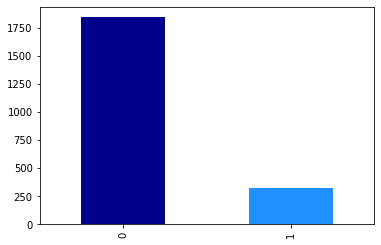

,id,E_pred
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,1
6,7,0
7,8,0
8,9,0
9,10,0


In [0]:
pred_mind_count = vect_mind.transform(test['lemma_no_stop'])

pred_mind_count.shape

X = X_count_mind
y = mind_df['E']

final_mind_model = mind_model
final_mind_model.fit(X, y)

final_mind_predictions = final_mind_model.predict(pred_mind_count)

test['E_pred'] = final_mind_predictions

test.head()

pred_mind_df = test[['id', 'E_pred']]

pred_mind_df.head(10)

pred_mind_df.columns

pred_mind_df['E_pred'].value_counts().plot(kind = 'bar',color = ['darkblue','dodgerblue'])

#pred_mind_df




plt.show()

pred_mind_df.head(10)

### Predicting energy

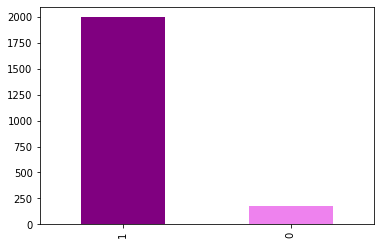

,id,N_pred
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,0
9,10,1


In [0]:
pred_energy_count = vect_energy.transform(test['lemma_no_stop'])

pred_energy_count.shape

X = X_count_energy
y = energy_df['N']

final_energy_model = energy_model
final_energy_model.fit(X, y)

final_energy_predictions = final_energy_model.predict(pred_energy_count)

test['N_pred'] = final_energy_predictions

pred_energy_df = test[['id', 'N_pred']]

pred_energy_df['N_pred'].value_counts().plot(kind = 'bar', color = ['purple','violet'])
plt.show()

pred_energy_df.head(10)

### Predicting nature

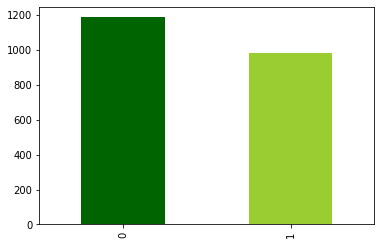

,id,T_pred
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,1
7,8,0
8,9,0
9,10,1


In [0]:
pred_nature_count = vect_nature.transform(test['lemma_no_stop'])

pred_nature_count.shape

X = X_count_nature
y = nature_df['T']

final_nature_model = nature_model
final_nature_model.fit(X, y)

final_nature_predictions = final_nature_model.predict(pred_nature_count)

test['T_pred'] = final_nature_predictions

pred_nature_df = test[['id', 'T_pred']]

pred_nature_df['T_pred'].value_counts().plot(kind = 'bar', color = ['darkgreen','yellowgreen'])
plt.show()

pred_nature_df.head(10)

### Predicting tactics

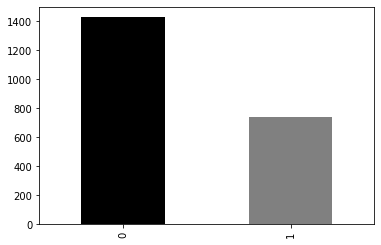

,id,J_pred
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1
5,6,0
6,7,1
7,8,0
8,9,0
9,10,0


In [0]:
pred_tactics_count = vect_tactics.transform(test['lemma_no_stop'])

pred_tactics_count.shape

X = X_count_tactics
y = tactics_df['J']

final_tactics_model = tactics_model
final_tactics_model.fit(X, y)

final_tactics_predictions = final_tactics_model.predict(pred_tactics_count)

test['J_pred'] = final_tactics_predictions

pred_tactics_df = test[['id', 'J_pred']]

pred_tactics_df['J_pred'].value_counts().plot(kind = 'bar', color = ['black','grey'])


plt.show()

pred_tactics_df.head(10)

In [0]:
my_submission = pd.merge(pred_mind_df[['id','E_pred']], pred_energy_df[['id','N_pred']], how ='inner', on ='id') 
my_submission = pd.merge(my_submission[['id','E_pred', 'N_pred']], pred_nature_df[['id','T_pred']], how ='inner', on ='id')
my_submission = pd.merge(my_submission[['id','E_pred', 'N_pred','T_pred']], pred_tactics_df[['id','J_pred']], how ='inner', on ='id') 

In [0]:
my_submission.head(10)

,id,E_pred,N_pred,T_pred,J_pred
0,1,0,1,0,0
1,2,0,1,0,0
2,3,0,1,0,1
3,4,0,1,0,0
4,5,0,1,0,1
5,6,1,1,0,0
6,7,0,1,1,1
7,8,0,1,0,0
8,9,0,0,0,0
9,10,0,1,1,0


In [0]:
my_submission.rename(columns={'id':'id',
                            'E_pred':'mind',
                            'N_pred': 'energy',
                            'T_pred': 'nature',
                            'J_pred': 'tactics'
                             }, 
                 inplace=True)

my_submission.head()

,id,mind,energy,nature,tactics
0,1,0,1,0,0
1,2,0,1,0,0
2,3,0,1,0,1
3,4,0,1,0,0
4,5,0,1,0,1


In [0]:
my_submission.to_csv('Classification_project_final_submission.csv', index=False)

# Conclusion

In [0]:
# Create column for the predictions of each of the 4 chracteristics
my_submission['Mind Pred'] = my_submission['mind'].map(lambda x: 'E' if x == 1 else 'I')
my_submission['Energy Pred'] = my_submission['energy'].map(lambda x: 'N' if x == 1 else 'S')
my_submission['Nature Pred'] = my_submission['nature'].map(lambda x: 'T' if x == 1 else 'F')
my_submission['Tactics Pred'] = my_submission['tactics'].map(lambda x: 'J' if x == 1 else 'P')

In [0]:
my_submission.head()

,id,mind,energy,nature,tactics,Mind Pred,Energy Pred,Nature Pred,Tactics Pred
0,1,0,1,0,0,I,N,F,P
1,2,0,1,0,0,I,N,F,P
2,3,0,1,0,1,I,N,F,J
3,4,0,1,0,0,I,N,F,P
4,5,0,1,0,1,I,N,F,J


In [0]:
my_submission['Personality Pred'] = my_submission['Mind Pred'] + my_submission['Energy Pred'] + my_submission['Nature Pred']+ my_submission['Tactics Pred']

In [0]:
my_submission[['id','Personality Pred']].head()

,id,Personality Pred
0,1,INFP
1,2,INFP
2,3,INFJ
3,4,INFP
4,5,INFJ


In [0]:
mbti_type = ['ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']
global_p = [ 2.5, 8.1, 1.8, 3.2, 12.3, 8.5, 8.7, 4.3, 1.5, 4.4, 2.1, 3.3, 13.8, 8.8, 11.6, 5.4]

In [0]:
global_types = {'Type':mbti_type,'Percentage':global_p}

In [0]:
global_df = pd.DataFrame(global_types)
global_df

,Type,Percentage
0,ENFJ,2.5
1,ENFP,8.1
2,ENTJ,1.8
3,ENTP,3.2
4,ESFJ,12.3
5,ESFP,8.5
6,ESTJ,8.7
7,ESTP,4.3
8,INFJ,1.5
9,INFP,4.4


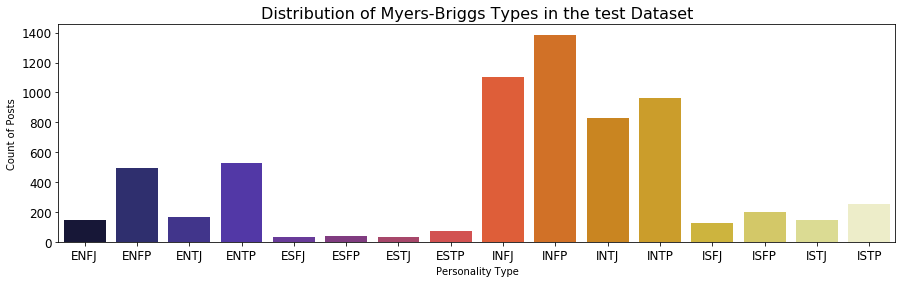

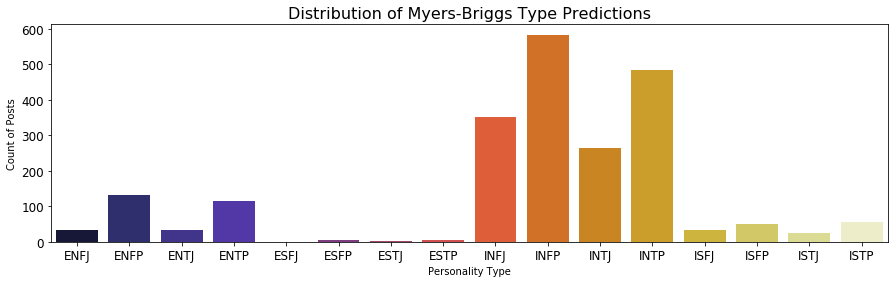

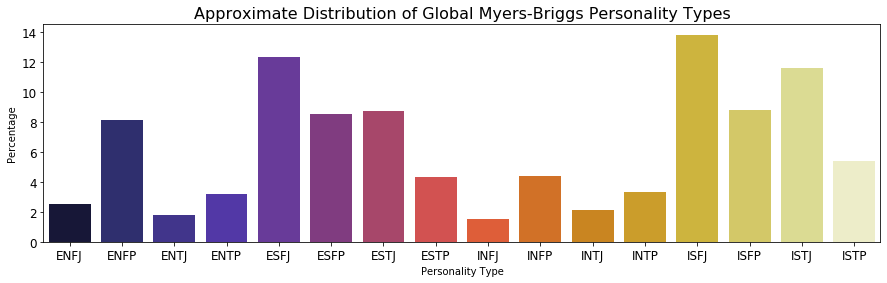

In [0]:
#view posts count of each personality type
# Countplot of the 16 personality types in the dataset
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
cmrmap = sns.color_palette('CMRmap', 16)
sns.set_palette(cmrmap)
sns.countplot(x='type', data=train,\
              order=['ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP',\
                    'INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP'])
plt.title('Distribution of Myers-Briggs Types in the test Dataset', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Count of Posts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



#view posts count of each personality type
# Countplot of the 16 personality types in the dataset
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
cmrmap = sns.color_palette("CMRmap", 16)
sns.set_palette(cmrmap)
sns.countplot(x='Personality Pred', data=my_submission,\
              order=['ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP',\
                    'INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP'])
plt.title('Distribution of Myers-Briggs Type Predictions', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Count of Posts')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



#view posts count of each personality type
# Countplot of the 16 personality types in the dataset
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
cmrmap = sns.color_palette("CMRmap", 16)
sns.set_palette(cmrmap)
sns.barplot(x='Type', y='Percentage', data=global_df, order=['ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP',\
                   'INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP'])
plt.title('Approximate Distribution of Global Myers-Briggs Personality Types', fontsize=16)
plt.xlabel('Personality Type')
plt.ylabel('Percentage')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()




As observed from above, the data used to train and test the model does not represent the overall amount of personalities worldwide. Our data has more 'INFP' personality types whilst the worldwide data has the 'ISFJ' personality being more prevalent. The personality type that is smaller in number worldwide is 'INFJ' but according to our data the 'ESFJ' and 'ESTJ' personalities are the ones that are fewer. This is possibly due to the personalities that used the Personality Cafe website forum which shows that the individuals used to collect the data had a low amount of extroverted personalities(especially 'ES' personalities) and had a high amount of introverted personalities(especially 'IN' personalities)